## imports / setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
import torch
from torch import optim, nn
import PIL 
import pydicom

from functools import partial, reduce
from enum import Enum

In [3]:
# helper function from the competition
import mask_functions

# helpers

In [4]:
def ls(p, re='*'):
    return [i for i in p.glob(re)]

In [74]:
def getImg(fpath):
    ds = pydicom.read_file( fpath) # read dicom image
    return ds.pixel_array, ds # get image array
    
def getMask(imgId, df, shape):
    """returns nd array mask"""
    df = df.loc[df['ImageId'] == imgId]
    rle_r = df['EncodedPixels'].tolist()
    
    rle = ''
    if len(rle_r) > 0:
        rle = rle_r[0].strip()

    mask = np.zeros([*shape])
    if not rle == '-1':
        mask = mask_functions.rle2mask(rle, *shape)
        mask = np.flip(mask, axis=0)
        mask = np.rot90(mask, -1)
    return mask

def getImageAndMask(fname, labels):
    imgf = fname 
    imgPath = str(imgf)
    imgId = imgf.stem
    img,_ = getImg( imgPath )
    mask = getMask(imgId, df=labels, shape=img.shape)
    return img, mask

In [75]:
def plot_multi(fn, size=[1,1], item_list=[]):
    fig, ax = plt.subplots(size[0],size[1], figsize=(40,60))
    print(type(ax))
    
    ax = ax.flatten()
    for idx, a in enumerate(ax):
        if not idx > (len(item_list)-1):
            item = item_list[idx]
            fn(a, item)
                 
def plot_xray_mask(a, item, df, show_mask=True):
    img, mask = getImageAndMask(item, labels=df)
    a.imshow(img, cmap=plt.cm.bone)
    # if mask
    if not np.all(mask == 0): 
        a.set_title('Pneumothorax Present')
        a.imshow(mask, alpha=0.3, cmap='Reds')
        
def plot_xray(a, img):
    a.imshow(img, cmap=plt.cm.bone)

detach = lambda ten: ten.detach().numpy()[0]
    
def plot_xyhat(arr):
    item_list =[ detach(x) for x in arr ]

    plot_multi(plot_xray, size=[1,3], item_list=item_list)

# full data path!

In [76]:
# get sample data
path = Path('/home/ubuntu/data/fastai/data/siim-acr/')

In [77]:
fnames = []
for p in ls(path/'dicom-images-train'):
#     print(ls(p))
    for pp in ls(p):
#         print(len(ls(pp)))
        fnames.append(*ls(pp))

In [82]:
labels_path = path/'train-rle.csv'

In [83]:
labelsdf = pd.read_csv(labels_path).rename(columns={' EncodedPixels':'EncodedPixels'})

# Dataloader

In [47]:
from torch.utils.data import Dataset, dataloader

In [48]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [49]:
# lazy load the masks and images
class Xray(Dataset):
    def __init__(self):
        self.len = len(fnames)
        
    def __getitem__(self, index):
        x,y = getImageAndMask(fnames[index], labelsdf)
        x = torch.Tensor(x).view(1, 1024, 1024).to(dev)
        y = torch.Tensor(y).view(1, 1024, 1024).to(dev)
        return x, y
        
    def __len__(self):
        return self.len
    

In [50]:
ds = Xray()

In [51]:
ds[149]

[' -1'] 1.2.276.0.7230010.3.1.4.8323329.1378.1517875167.457297


(tensor([[[ 1.,  1.,  1.,  ...,  0.,  0.,  0.],
          [ 1.,  1.,  1.,  ...,  0.,  0.,  0.],
          [ 1.,  1.,  1.,  ...,  0.,  0.,  0.],
          ...,
          [ 4., 12., 13.,  ...,  0.,  0.,  0.],
          [ 4., 10., 12.,  ...,  0.,  0.,  0.],
          [ 3.,  5.,  7.,  ...,  0.,  0.,  0.]]], device='cuda:0'),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'))

In [84]:
dl = dataloader.DataLoader(ds, batch_size=64, shuffle=True, num_workers=0)

In [85]:
dli = iter(dl)

In [86]:
xb, yb = next(dli)

In [68]:
xb.shape, xb.view([1,-1]).shape[1]

(torch.Size([64, 1, 1024, 1024]), 67108864)

In [69]:
 xb[0].view([1,-1]).view([1,1024,1024]).dim()

3

In [70]:
xb[0].view([1,-1]).dim()

2

In [71]:
xb, yb = next(dli)

[' -1'] 1.2.276.0.7230010.3.1.4.8323329.4498.1517875183.161530
[' 621743 2 1018 8 1015 10 1013 13 1010 14 1008 18 1005 20 1004 21 1002 22 1002 22 1002 23 1000 24 1000 25 999 25 999 25 998 26 998 26 998 26 998 27 997 27 997 27 996 28 996 28 996 28 996 28 996 28 996 28 996 28 996 28 996 29 995 29 995 29 995 29 995 29 995 29 995 29 995 29 995 29 995 29 995 29 995 29 995 29 995 29 995 29 995 29 995 29 995 28 996 28 996 28 996 28 996 28 997 27 997 27 997 27 997 27 997 27 997 27 998 26 998 26 998 26 999 25 999 24 1000 24 1001 23 1001 23 1002 22 1002 22 1003 21 1003 21 1004 20 1004 19 1006 18 1007 16 1008 16 1008 15 1010 14 1011 13 1011 12 1013 11 1013 11 1014 10 1015 8 1017 7'] 1.2.276.0.7230010.3.1.4.8323329.31761.1517875156.675901
[' -1'] 1.2.276.0.7230010.3.1.4.8323329.5318.1517875187.609974
[' 556397 14 1007 21 1001 25 998 28 995 30 993 31 992 32 992 32 991 33 991 33 991 33 990 34 990 34 990 34 990 34 990 34 989 35 989 35 989 34 990 34 990 34 989 35 989 35 989 35 989 34 990 34 990 34 989

[' -1'] 1.2.276.0.7230010.3.1.4.8323329.2798.1517875174.783709
[' -1'] 1.2.276.0.7230010.3.1.4.8323329.4251.1517875181.906255
[' 729778 7 1016 9 1014 10 1014 10 1013 12 1012 12 1011 13 1011 13 1011 13 1010 14 1010 13 1011 13 1010 14 1010 14 1010 13 1010 14 1010 14 1010 13 1010 14 1009 15 1009 14 1009 15 1008 16 1007 17 1006 17 1006 18 1006 18 1005 18 1006 18 1006 18 1005 19 1005 18 1006 18 1006 18 1005 19 1005 19 1005 19 1005 18 1006 18 1005 19 1005 19 1005 19 1005 19 1005 19 1004 20 1004 20 1004 20 1004 19 1005 19 1004 20 1004 20 1004 20 1004 20 1003 21 1003 21 1003 21 1002 22 1002 22 1002 21 1003 21 1003 21 1003 21 1002 22 1002 21 1003 21 1003 21 1003 21 1002 22 1002 22 1002 22 1002 22 1002 22 1001 23 1001 23 1001 23 1001 23 1000 24 1000 24 1000 24 1000 24 999 25 999 25 999 25 998 26 998 26 998 26 997 27 997 27 997 27 997 27 996 28 996 28 996 28 996 27 997 27 996 28 996 29 995 29 995 29 994 30 994 30 993 31 993 31 992 32 992 32 991 34 989 35 989 35 988 36 987 37 987 37 986 39 984 40 

[' -1'] 1.2.276.0.7230010.3.1.4.8323329.14544.1517875252.646836
[' -1'] 1.2.276.0.7230010.3.1.4.8323329.14329.1517875251.340220
[' -1'] 1.2.276.0.7230010.3.1.4.8323329.13978.1517875248.944736
[' 204351 27 982 52 962 67 948 81 933 93 926 101 814 12 87 112 808 22 72 123 802 32 57 133 792 46 43 142 783 58 31 152 753 91 13 166 724 298 716 304 715 304 715 299 720 279 740 274 745 269 752 267 754 265 757 257 764 250 771 243 778 236 785 229 793 221 800 214 808 212 810 204 818 201 820 194 828 191 831 188 834 185 837 182 841 173 849 170 852 167 855 165 856 166 856 165 857 162 860 160 861 160 862 159 863 157 865 157 865 156 866 154 869 152 870 152 870 152 870 152 870 151 871 151 871 150 873 149 873 149 873 149 873 148 875 147 875 147 876 146 875 147 875 148 875 147 875 147 876 146 877 145 877 145 878 144 879 144 878 144 879 144 879 143 879 144 879 143 880 142 880 143 880 142 881 142 880 143 880 142 881 142 880 143 880 142 881 142 882 141 882 140 883 140 883 140 882 140 883 140 883 140 884 138 885

<class 'numpy.ndarray'>


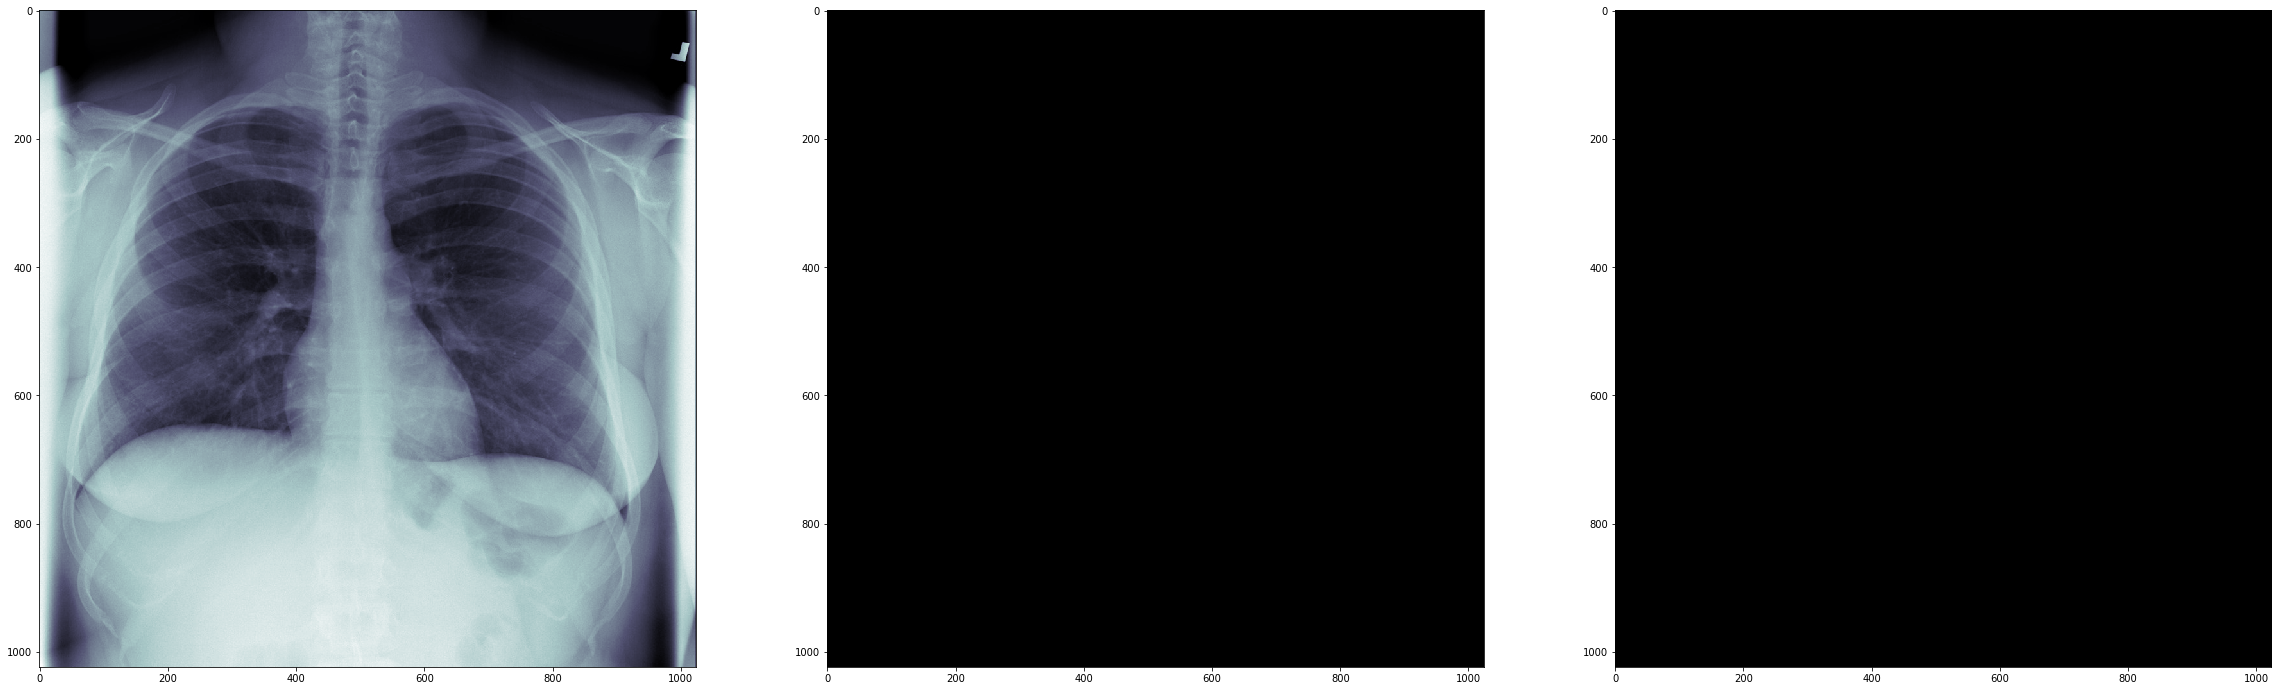

In [72]:
plot_xyhat([x.cpu()[0] for x in  [xb, yb, yb]])